## Rover_Project_Test_Notebook

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob
import imageio
import pandas as pd

## Quick Look at the Data
There's some data provided in the `data` folder.
Next, read in and display a random image from the `data` folder.

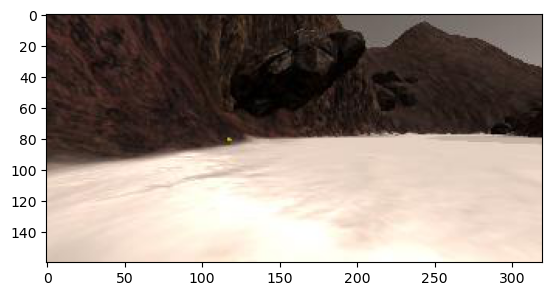

In [2]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

In [3]:
# Function for plotting
def plot1(img1, title1):
    fig = plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title(title1)
    
def plot2(img1, img2 , title1, title2):
    fig = plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.imshow(img1)
    plt.title(title1)
    plt.subplot(122)
    plt.imshow(img2)
    plt.title(title2)
    
def plot2gray(img1, img2 , title1, title2):
    fig = plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray')
    plt.title(title1)
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')
    plt.title(title2)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

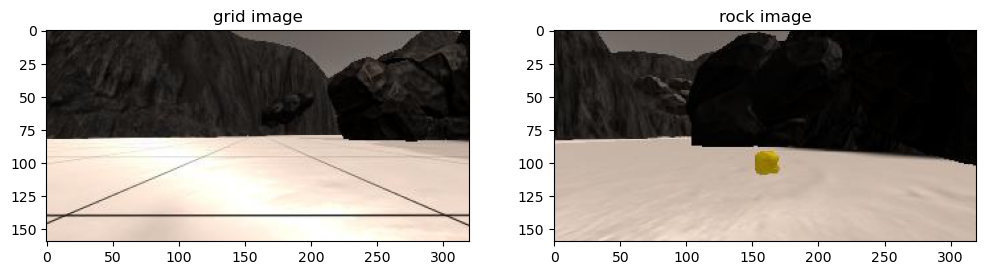

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  

# Here's an example of the grid and one of the rocks
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

plot2(grid_img, rock_img, 'grid image', 'rock image')

## Perspective Transform

Define the perspective transform function and test it on an image.

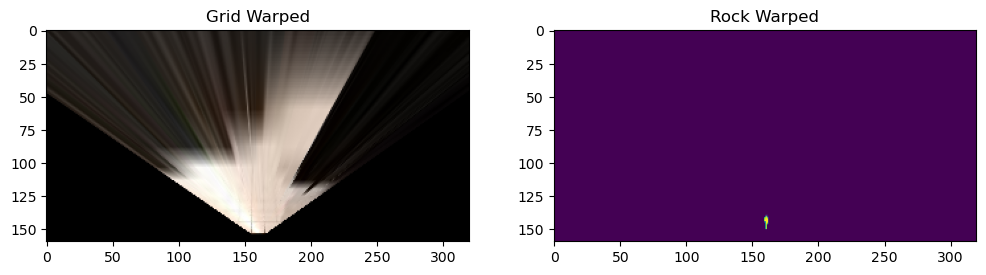

In [30]:
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))  # keep same size as input image
    mask = cv2.warpPerspective(np.ones_like(img[:, :, 0]), M, (img.shape[1], img.shape[0]))
    return warped, mask

def perspect_transform2(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))  # keep same size as input image
    return warped

def impose_range(xpix, ypix, range=80):
    dist = np.sqrt(xpix ** 2 + ypix ** 2)
    return xpix[dist < range], ypix[dist < range]


#used a destination size of 10, for better fidelity, this does mess with collisions, need optimal number for phase 2
#offset of the warped image from the bottom
dst_size = 5
bottom_offset = 6


source = np.float32(([14,140],[300,140],[200,95],[120,95]))
destination = np.float32(([image.shape[1]/2 - dst_size, image.shape[0]-bottom_offset],
                         [image.shape[1]/2+dst_size, image.shape[0]-bottom_offset],
                         [image.shape[1]/2+dst_size, image.shape[0]-2*dst_size-bottom_offset],
                         [image.shape[1]/2 -dst_size, image.shape[0]-2*dst_size-bottom_offset]))
# these source and destination points are used to warp the given image
warped = perspect_transform2(grid_img, source, destination)
warped_rock = perspect_transform2(rock_img, source, destination)
lower_yellow = np.array([24 - 5, 100, 100])
upper_yellow = np.array([24 + 5, 255, 255])
# Convert BGR to HSV
rockMap_hsv = cv2.cvtColor(rock_img, cv2.COLOR_RGB2HSV)
# Threshold the HSV image to get only upper_yellow colors
rockMap = cv2.inRange(rockMap_hsv, lower_yellow, upper_yellow)
rockMap_warped = perspect_transform2(rockMap, source, destination)

plot2(warped, rockMap_warped, 'Grid Warped', 'Rock Warped')

# imageio.imwrite('../output/warped_example_grid.jpg', warped)
# imageio.imwrite('../output/warped_example_rock.jpg', warped_rock)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function and apply it to the warped image

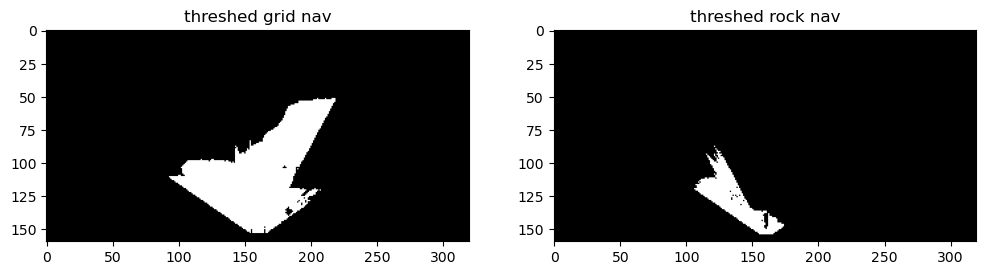

In [31]:
def color_thresh(img, rgb_thresh=(160,160,160),types=0):
    color_select =np.zeros_like(img[:,:,0])
    if types == 0:
        above_thresh = (img[:,:,0]>rgb_thresh[0])&(img[:,:,1]>rgb_thresh[1])&(img[:,:,2]>rgb_thresh[2])  # for navigable
    elif types == 1:
        above_thresh = (img[:,:,0]>rgb_thresh[0])&(img[:,:,1]>rgb_thresh[1])&(img[:,:,2]<rgb_thresh[2])#for rocks
    else:
        above_thresh = (img[:,:,0]>0)&(img[:,:,1]>0)&(img[:,:,2]>0)#for mask
    color_select[above_thresh] = 1
    return color_select

threshed = color_thresh(warped)
threshed_rock = color_thresh(warped_rock)
plot2gray(threshed, threshed_rock, 'threshed grid nav', 'threshed rock nav')
# imageio.imwrite('../output/threshed_example_grid_nav.jpg', threshed*255)
# imageio.imwrite('../output/threshed_example_rock_nav.jpg', threshed_rock*255)
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

# Adjust to world Coordinates

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

In [ ]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the
    # center bottom of the image.
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1] / 2).astype(np.float32)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle)
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel ** 2 + y_pixel ** 2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles


# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))

    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result
    return xpix_rotated, ypix_rotated


def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

In [ ]:
# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform2(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(222)
plt.imshow(warped)
plt.title('Warped')
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.title('Thresholded')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.title('Rover-centric Coords')

# fig.savefig('../output/myoutput.jpg')

In [ ]:

# this is the path to the csv file
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
# list of image paths
csv_img_list = df["Path"].tolist() 

# creating 3 channel image for the map
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)






#  this class  will be a container. it will read each row from the csv file and create an object corresponds to it
class DataContainer():
    def __init__(self):
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.images = csv_img_list  
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap


data = DataContainer()


In [ ]:
#stored images will be passed to this function
def process_image(img):
   
        
        #creating an empty image with zeros
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        
        # the original image will be in the upper left corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        #This is the warped image (perspective transformed) that is to be included too.
    warped = perspect_transform2(img, source, destination)
    
        # the warped image will be in the upper right
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # it add the navigable terrain and the obstacles to the mini-map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    
    #moviepy skipping images bug fix
        
    if data.count < len(data.images) - 1:
        data.count += 1 
    
    return output_image

In [ ]:
#fixing ffmpeg path bug 
import os
# os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/local/bin/ffmpeg"
os.environ["IMAGEIO_FFMPEG_EXE"] = "/home/kimo/anaconda3/pkgs/ffmpeg-4.2.2-h20bf706_0/bin/ffmpeg"

from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# this will be the output video
output = '../testVideo.mp4'
data = DataContainer() # Re-initialize the DataContainer
clip = ImageSequenceClip(data.images, fps=60) 

new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

In [ ]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))